In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.autonotebook import tqdm
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder
import time
import os
import copy
import seaborn as sn
import splitfolders
import pandas as pd
import torchnet.meter.confusionmeter as cm
from sklearn.metrics import classification_report

C:\Users\admin\AppData\Local\Temp\ipykernel_8916\212258244.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
"""
# Path to the folder containing images
folder_path = "D:/Segmentation And Classification/Output"
image_files = os.listdir(folder_path)

# split data in a new folder named data-split
splitfolders.ratio("D:/Segmentation And Classification/Output", output="D:/Segmentation And Classification/Data-Splitting", seed=1337,ratio=(0.75, 0.15, 0.1), group_prefix=None, move=False)
"""


'\n# Path to the folder containing images\nfolder_path = "D:/Segmentation And Classification/Output"\nimage_files = os.listdir(folder_path)\n\n# split data in a new folder named data-split\nsplitfolders.ratio("D:/Segmentation And Classification/Output", output="D:/Segmentation And Classification/Data-Splitting", seed=1337,ratio=(0.75, 0.15, 0.1), group_prefix=None, move=False)\n'

In [3]:
data_dir = 'D:/Segmentation And Classification/Data-Splitting'
os.cpu_count()

12

In [4]:
class EarlyStopping:
    def __init__(self, patience=0, verbose=False, delta=0):
        """
        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            verbose (bool): If True, prints a message for each epoch where the validation loss improves.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        """
        Args:
            val_loss (float): Validation loss to monitor for improvement.
        Returns:
            bool: True if training should be stopped based on the validation loss, False otherwise.
        """
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
        return self.early_stop

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation & test
BATCH = 190
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    early_stopping = EarlyStopping(patience=40, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "train":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "val":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #for printing        
            if phase == "train":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "val":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model if it's the best one yet
            if phase == 'val'  and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # Save the best model checkpoint if desired
            # torch.save(model.state_dict(), 'best_model.pth')

            # Check if early stopping criteria are met
            if phase == 'val'  and early_stopping(epoch_loss):
                print("Early stopping triggered.")
                break
            
            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # Save the best model checkpoint if desired
            # torch.save(model.state_dict(), 'best_model.pth')

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model       

  0%|          | 0/40 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.79E-03


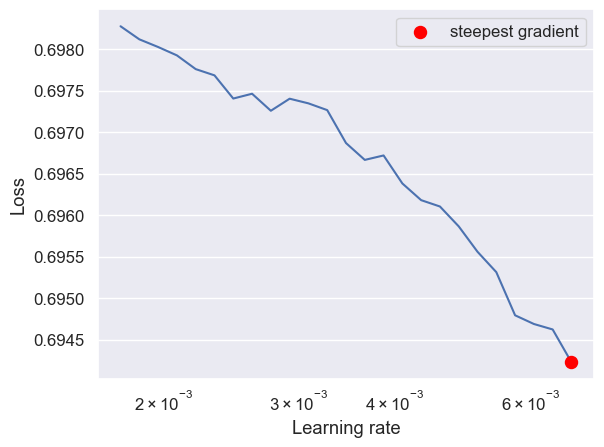

Optimal Learning Rate: 0.009000000000000001
Epoch 1/10
----------


C:\Users\admin\anaconda3\envs\Projects\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.0248 Acc: 0.5253
val Loss: 0.5625 Acc: 0.7148

Epoch 2/10
----------
train Loss: 0.5629 Acc: 0.7156
val Loss: 0.5077 Acc: 0.7887

Epoch 3/10
----------
train Loss: 0.5315 Acc: 0.7472
val Loss: 0.5487 Acc: 0.7218
EarlyStopping counter: 1 out of 40

Epoch 4/10
----------
train Loss: 0.5167 Acc: 0.7542
val Loss: 0.4893 Acc: 0.7746

Epoch 5/10
----------
train Loss: 0.4454 Acc: 0.7963
val Loss: 0.4793 Acc: 0.7535

Epoch 6/10
----------
train Loss: 0.3909 Acc: 0.8420
val Loss: 0.4335 Acc: 0.8099

Epoch 7/10
----------
train Loss: 0.3689 Acc: 0.8603
val Loss: 0.4102 Acc: 0.8239

Epoch 8/10
----------
train Loss: 0.3354 Acc: 0.8855
val Loss: 0.4223 Acc: 0.8169
EarlyStopping counter: 1 out of 40

Epoch 9/10
----------
train Loss: 0.3553 Acc: 0.8539
val Loss: 0.4954 Acc: 0.7887
EarlyStopping counter: 2 out of 40

Epoch 10/10
----------
train Loss: 0.3071 Acc: 0.8792
val Loss: 0.4010 Acc: 0.8239

Training complete in 9m 17s
Best val Acc: 0.823944


In [19]:
STEPS_PER_EPOCH = int(np.ceil(1900 / BATCH))
#For resnet50
model_ft = models.resnet50(weights='DEFAULT')
for parameter in model_ft.parameters(): 
    parameter.requires_grad = False # Freezing Layers
num_features = model_ft.fc.in_features
num_classes = 2
model_ft.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.Dropout(0.1),  # Add Dropout with a dropout rate of 0.1
    nn.Linear(256, num_classes)
)
model_ft.eval()

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft_finder = optim.SGD(model_ft.parameters(), lr=1e-3)  # Set your desired initial learning rate

# Initialize the LR Finder with your model, optimizer, criterion, and device
lr_finder = LRFinder(model_ft, optimizer_ft_finder, criterion, device=device)

# Run the LR Finder with a range of learning rates
lr_finder.range_test(dataloaders['train'], end_lr=9e-3, num_iter=40)

# Plot the learning rate vs. loss
lr_finder.plot()

# Reset the model and optimizer to their initial state
model_ft.train()

# Reset the LR finder before accessing its properties
lr_finder.reset()

# Get the optimal learning rate suggested by the LR Finder
optimal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print(f"Optimal Learning Rate: {optimal_lr}")

# Using Adam as the parameter optimizer with the optimal learning rate
optimizer_ft = optim.Adam(model_ft.parameters(), lr=optimal_lr, weight_decay=0.03)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEPS_PER_EPOCH, gamma=0.1)

# Training The Model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

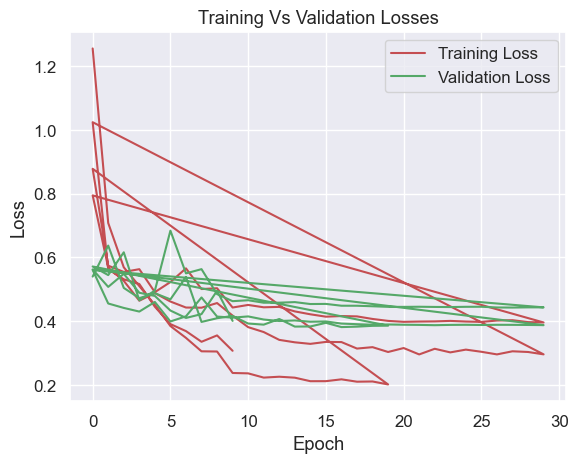

In [20]:
#Plot the train & validation losses
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()

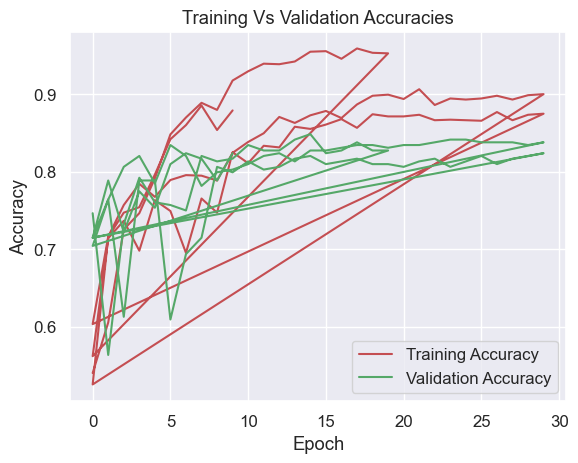

In [21]:
# Convert train_acc and val_acc to numpy arrays
train_acc_np = np.array([acc.cpu().numpy() for acc in train_acc])
val_acc_np = np.array([acc.cpu().numpy() for acc in val_acc])

# Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train, train_acc_np, color='r', label="Training Accuracy")
plt.plot(epoch_counter_val, val_acc_np, color='g', label="Validation Accuracy")
plt.legend()
plt.show()

Accuracy of the network on the test images: 84 %
              precision    recall  f1-score   support

Bot Beer 320       0.84      0.84      0.84        96
Bot Beer 620       0.84      0.84      0.84        96

    accuracy                           0.84       192
   macro avg       0.84      0.84      0.84       192
weighted avg       0.84      0.84      0.84       192

Accuracy of Bot Beer 320 : 84 %
Accuracy of Bot Beer 620 : 84 %
[[81 15]
 [15 81]]


<Axes: >

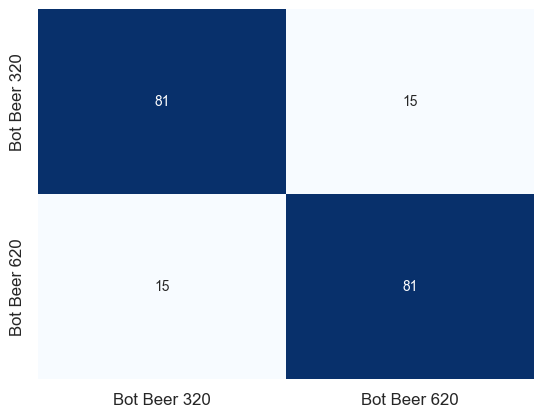

In [22]:
#Test the accuracy with test data
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# Calculate precision, recall, F1-score, and support using sklearn's classification_report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

#Class wise testing accuracy
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(2)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set_theme(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 